In [1]:
PATH_data_source = "../data/source/"
PATH_data_output = "../data/output/"
PATH_model = "../model/"

In [7]:
import pandas as pd
import numpy as np
import shap
import sklearn
import plotly.express as px
import plotly.graph_objects as go
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import classification_report
import math

from aif360.sklearn.metrics import equal_opportunity_difference, statistical_parity_difference,average_odds_difference, disparate_impact_ratio, between_group_generalized_entropy_error

In [9]:
import sys
sys.path.append("../code/")
from utils import split_df_upper_lower_half


In [11]:
file_name = 'BangladeshiDiabetesRiskAssessment'
df = pd.read_csv(PATH_data_source + file_name + ".csv")
df

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


# Attack using Gender only

### Preprocess 
- select scoring features
- select protected features
- define baseline scoring function

In [19]:
# Preprocessing
X = df.drop(['class', 'Age'], axis=1)
X['Gender'] = X['Gender'].replace({'Male': 1, 'Female': 0})
X = X.replace({'Yes': 1, 'No': 0})
x = X.drop(['Gender'], axis=1) 

y = df['class']

C:\Users\user\AppData\Local\Temp\ipykernel_8460\877421279.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Gender'] = X['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\user\AppData\Local\Temp\ipykernel_8460\877421279.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({'Yes': 1, 'No': 0})


In [21]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train Naive Bayes Classifier
nb = GaussianNB()  
nb.fit(x_train, y_train)
predictions = nb.predict(x_test)

# Model Evaluation
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.82      0.87        40
    Positive       0.90      0.95      0.92        64

    accuracy                           0.90       104
   macro avg       0.91      0.89      0.90       104
weighted avg       0.90      0.90      0.90       104



In [23]:
def f(x):
    xx = pd.DataFrame(x[:, 1:])
    xx.columns = ['Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
                  'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
                  'Irritability', 'delayed healing', 'partial paresis',
                  'muscle stiffness', 'Alopecia', 'Obesity']
    return nb.predict_proba(xx)[:, 1]  # Updated: Use Naive Bayes for predictions

# Preprocess for Attacks
def preprocess(x):
    df = pd.DataFrame(x)
    df.columns = ['protected_attr', *df.columns[1:]]
    df['index'] = df.index
    df['s'] = f(x)
    df = df.sort_values(by=['s'], ascending=False)
    df_score_swap = df[['s', 'protected_attr', 'index']].reset_index(drop=True)
    return df_score_swap 


In [25]:
exec(open("../code/domSwapAttack.py").read())
exec(open("../code/mixSwapAttack.py").read())

In [27]:
model = MixSwapAttack_g

## fairness metrics calculate 


In [30]:
def get_data_test_grouped(group=['Gender', 'Age']):
    yy = df[['Gender', 'Age', 'class']]
    yy_train, yy_test = train_test_split(yy, test_size=0.2, random_state=0)
    y_test_g = yy_test[['Gender', 'Age', 'class']]
    y_test_g['Age'] = y_test_g['Age'] < df['Age'].median()
    y_test_g['Age'] = y_test_g['Age'].astype(int)
    y_test_g['class'] = y_test_g['class'].map({'Positive': 1, 'Negative': 0})
    y_test_g['Gender'] = y_test_g['Gender'].map({'Male': 1, 'Female': 0})
    return y_test_g

def get_data_pred_origin_shuffled(X_test, x_test, threshold):
    y_pred_shuffled = model(X_test.values) > threshold
    y_pred_shuffled = np.array([1 if e == True else 0 for e in y_pred_shuffled])
    y_pred = nb.predict_proba(x_test)[:, 1] > threshold  
    y_pred = np.array([1 if e == True else 0 for e in y_pred])
    return y_pred, y_pred_shuffled

def calc_fair_metrics(y_test, y_pred, priv_group=(1, 1)):
    return {
        "Equal Opportunity": equal_opportunity_difference(y_test, y_pred, priv_group=priv_group),
        "Demographic Parity": statistical_parity_difference(y_test, y_pred, priv_group=priv_group),
        "Equal Odds": average_odds_difference(y_test, y_pred, priv_group=priv_group),
        "Disparate Impact": disparate_impact_ratio(y_test, y_pred, priv_group=priv_group),
        "Theil Index": between_group_generalized_entropy_error(y_test, y_pred, priv_group=priv_group, alpha=1)
    }

def get_fairness_data(X_test, x_test, threshold, priv_group=['Gender', 'Age']):
    y_pred, y_pred_shuffled = get_data_pred_origin_shuffled(X_test, x_test, threshold)
    y_test_g = get_data_test_grouped(group=priv_group)
    if priv_group == ['Gender', 'Age']:
        pg = (1, 1)
    elif priv_group == ['Gender']:
        pg = (1)
        y_test_g = y_test_g.drop(['Age'], axis=1)
    else:
        pg = (1)
        y_test_g = y_test_g.drop(['Gender'], axis=1)

    y_test_g = y_test_g.set_index(priv_group)
    return {
        'origin': calc_fair_metrics(y_test_g.squeeze(), y_pred, priv_group=pg),
        'shuffled': calc_fair_metrics(y_test_g.squeeze(), y_pred_shuffled, priv_group=pg)
    }


In [32]:
get_fairness_data(X_test, x_test, threshold=0.9, priv_group=['Gender'])


score swap data here
swapping happened 41 times


C:\Users\user\Desktop\the product\shapFooling - naive bayes\experiments\../code\utils.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i1, :], df.iloc[i2, :] = b, a


{'origin': {'Equal Opportunity': -0.05490196078431375,
  'Demographic Parity': 0.39296066252587986,
  'Equal Odds': -0.09155354449472097,
  'Disparate Impact': 1.7974789915966385,
  'Theil Index': 0.002298885080636006},
 'shuffled': {'Equal Opportunity': -0.07254901960784321,
  'Demographic Parity': 0.22070393374741204,
  'Equal Odds': -0.19012066365007546,
  'Disparate Impact': 1.4007518796992482,
  'Theil Index': 0.011371474621437953}}

## Explain the attack function using SHAP

score swap data here
swapping happened 748 times
score swap data here
swapping happened 688 times
score swap data here
swapping happened 651 times
score swap data here
swapping happened 701 times
score swap data here
swapping happened 671 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 725 times
score swap data here
swapping happened 752 times
score swap data here
swapping happened 735 times
score swap data here
swapping happened 718 times
score swap data here
swapping happened 706 times
score swap data here
swapping happened 684 times
score swap data here
swapping happened 686 times
score swap data here
swapping happened 722 times
score swap data here
swapping happened 726 times
score swap data here
swapping happened 679 times


PermutationExplainer explainer:   1%|▌                                                         | 1/104 [00:00<?, ?it/s]

score swap data here
swapping happened 603 times
score swap data here
swapping happened 605 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 606 times
score swap data here
swapping happened 596 times
score swap data here
swapping happened 582 times
score swap data here
swapping happened 569 times
score swap data here
swapping happened 602 times
score swap data here
swapping happened 607 times
score swap data here
swapping happened 625 times
score swap data here
swapping happened 594 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 604 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 602 times
score swap data here
swapping happened 609 times
score swap data here


PermutationExplainer explainer:   3%|█▍                                                | 3/104 [00:31<11:48,  7.01s/it]

swapping happened 471 times
score swap data here
swapping happened 457 times
score swap data here
swapping happened 342 times
score swap data here
swapping happened 452 times
score swap data here
swapping happened 442 times
score swap data here
swapping happened 495 times
score swap data here
swapping happened 403 times
score swap data here
swapping happened 503 times
score swap data here
swapping happened 349 times
score swap data here
swapping happened 435 times
score swap data here
swapping happened 529 times
score swap data here
swapping happened 453 times
score swap data here
swapping happened 329 times
score swap data here
swapping happened 443 times
score swap data here
swapping happened 412 times
score swap data here
swapping happened 509 times
score swap data here
swapping happened 337 times
score swap data here


PermutationExplainer explainer:   4%|█▉                                                | 4/104 [00:44<15:21,  9.21s/it]

swapping happened 476 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 488 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 557 times
score swap data here
swapping happened 604 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 531 times
score swap data here
swapping happened 617 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 610 times
score swap data here
swapping happened 574 times
score swap data here
swapping happened 605 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 578 times
score swap data here
swapping happened 514 times
score swap data here


PermutationExplainer explainer:   5%|██▍                                               | 5/104 [00:58<18:36, 11.28s/it]

swapping happened 390 times
score swap data here
swapping happened 636 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 575 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 613 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 637 times
score swap data here
swapping happened 622 times
score swap data here
swapping happened 604 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 596 times
score swap data here
swapping happened 567 times
score swap data here
swapping happened 574 times
score swap data here
swapping happened 616 times
score swap data here


PermutationExplainer explainer:   6%|██▉                                               | 6/104 [01:12<20:03, 12.28s/it]

swapping happened 404 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 610 times
score swap data here
swapping happened 598 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 591 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 592 times
score swap data here
swapping happened 579 times
score swap data here
swapping happened 597 times
score swap data here
swapping happened 614 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 598 times
score swap data here
swapping happened 529 times
score swap data here
swapping happened 591 times
score swap data here


PermutationExplainer explainer:   7%|███▎                                              | 7/104 [01:27<21:20, 13.20s/it]

swapping happened 462 times
score swap data here
swapping happened 557 times
score swap data here
swapping happened 567 times
score swap data here
swapping happened 541 times
score swap data here
swapping happened 569 times
score swap data here
swapping happened 576 times
score swap data here
swapping happened 561 times
score swap data here
swapping happened 556 times
score swap data here
swapping happened 571 times
score swap data here
swapping happened 584 times
score swap data here
swapping happened 607 times
score swap data here
swapping happened 570 times
score swap data here
swapping happened 591 times
score swap data here
swapping happened 552 times
score swap data here
swapping happened 570 times
score swap data here
swapping happened 573 times
score swap data here
swapping happened 563 times
score swap data here


PermutationExplainer explainer:   8%|███▊                                              | 8/104 [01:41<21:26, 13.40s/it]

swapping happened 440 times
score swap data here
swapping happened 678 times
score swap data here
swapping happened 715 times
score swap data here
swapping happened 697 times
score swap data here
swapping happened 699 times
score swap data here
swapping happened 658 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 674 times
score swap data here
swapping happened 665 times
score swap data here
swapping happened 695 times
score swap data here
swapping happened 680 times
score swap data here
swapping happened 668 times
score swap data here
swapping happened 636 times
score swap data here
swapping happened 606 times
score swap data here
swapping happened 644 times
score swap data here
swapping happened 699 times
score swap data here
swapping happened 643 times
score swap data here


PermutationExplainer explainer:   9%|████▎                                             | 9/104 [01:56<22:05, 13.95s/it]

swapping happened 454 times
score swap data here
swapping happened 729 times
score swap data here
swapping happened 733 times
score swap data here
swapping happened 703 times
score swap data here
swapping happened 727 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 678 times
score swap data here
swapping happened 641 times
score swap data here
swapping happened 664 times
score swap data here
swapping happened 748 times
score swap data here
swapping happened 670 times
score swap data here
swapping happened 706 times
score swap data here
swapping happened 761 times
score swap data here
swapping happened 712 times
score swap data here
swapping happened 665 times
score swap data here
swapping happened 699 times
score swap data here
swapping happened 745 times
score swap data here


PermutationExplainer explainer:  10%|████▋                                            | 10/104 [02:13<23:07, 14.76s/it]

swapping happened 481 times
score swap data here
swapping happened 419 times
score swap data here
swapping happened 512 times
score swap data here
swapping happened 441 times
score swap data here
swapping happened 450 times
score swap data here
swapping happened 325 times
score swap data here
swapping happened 435 times
score swap data here
swapping happened 488 times
score swap data here
swapping happened 330 times
score swap data here
swapping happened 420 times
score swap data here
swapping happened 473 times
score swap data here
swapping happened 478 times
score swap data here
swapping happened 449 times
score swap data here
swapping happened 331 times
score swap data here
swapping happened 505 times
score swap data here
swapping happened 457 times
score swap data here
swapping happened 466 times
score swap data here


PermutationExplainer explainer:  11%|█████▏                                           | 11/104 [02:24<21:01, 13.56s/it]

swapping happened 479 times
score swap data here
swapping happened 706 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 651 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 648 times
score swap data here
swapping happened 622 times
score swap data here
swapping happened 701 times
score swap data here
swapping happened 688 times
score swap data here
swapping happened 687 times
score swap data here
swapping happened 697 times
score swap data here
swapping happened 662 times
score swap data here
swapping happened 682 times
score swap data here
swapping happened 670 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 588 times
score swap data here


PermutationExplainer explainer:  12%|█████▋                                           | 12/104 [02:39<21:46, 14.20s/it]

swapping happened 441 times
score swap data here
swapping happened 611 times
score swap data here
swapping happened 646 times
score swap data here
swapping happened 547 times
score swap data here
swapping happened 587 times
score swap data here
swapping happened 591 times
score swap data here
swapping happened 553 times
score swap data here
swapping happened 595 times
score swap data here
swapping happened 622 times
score swap data here
swapping happened 595 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 632 times
score swap data here
swapping happened 650 times
score swap data here
swapping happened 583 times
score swap data here
swapping happened 605 times
score swap data here
swapping happened 588 times
score swap data here
swapping happened 629 times
score swap data here


PermutationExplainer explainer:  12%|██████▏                                          | 13/104 [02:54<21:34, 14.23s/it]

swapping happened 415 times
score swap data here
swapping happened 745 times
score swap data here
swapping happened 757 times
score swap data here
swapping happened 720 times
score swap data here
swapping happened 744 times
score swap data here
swapping happened 686 times
score swap data here
swapping happened 754 times
score swap data here
swapping happened 689 times
score swap data here
swapping happened 730 times
score swap data here
swapping happened 717 times
score swap data here
swapping happened 730 times
score swap data here
swapping happened 757 times
score swap data here
swapping happened 812 times
score swap data here
swapping happened 778 times
score swap data here
swapping happened 761 times
score swap data here
swapping happened 742 times
score swap data here
swapping happened 736 times
score swap data here


PermutationExplainer explainer:  13%|██████▌                                          | 14/104 [03:11<22:44, 15.16s/it]

swapping happened 528 times
score swap data here
swapping happened 336 times
score swap data here
swapping happened 301 times
score swap data here
swapping happened 336 times
score swap data here
swapping happened 286 times
score swap data here
swapping happened 321 times
score swap data here
swapping happened 302 times
score swap data here
swapping happened 299 times
score swap data here
swapping happened 337 times
score swap data here
swapping happened 267 times
score swap data here
swapping happened 301 times
score swap data here
swapping happened 312 times
score swap data here
swapping happened 335 times
score swap data here
swapping happened 336 times
score swap data here
swapping happened 344 times
score swap data here
swapping happened 306 times
score swap data here
swapping happened 364 times
score swap data here


PermutationExplainer explainer:  14%|███████                                          | 15/104 [03:19<19:24, 13.08s/it]

swapping happened 414 times
score swap data here
swapping happened 596 times
score swap data here
swapping happened 610 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 490 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 566 times
score swap data here
swapping happened 595 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 536 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 489 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 591 times
score swap data here
swapping happened 592 times
score swap data here
swapping happened 548 times
score swap data here


PermutationExplainer explainer:  15%|███████▌                                         | 16/104 [03:34<19:49, 13.51s/it]

swapping happened 432 times
score swap data here
swapping happened 324 times
score swap data here
swapping happened 504 times
score swap data here
swapping happened 486 times
score swap data here
swapping happened 412 times
score swap data here
swapping happened 442 times
score swap data here
swapping happened 464 times
score swap data here
swapping happened 253 times
score swap data here
swapping happened 432 times
score swap data here
swapping happened 368 times
score swap data here
swapping happened 441 times
score swap data here
swapping happened 479 times
score swap data here
swapping happened 467 times
score swap data here
swapping happened 455 times
score swap data here
swapping happened 318 times
score swap data here
swapping happened 406 times
score swap data here
swapping happened 448 times
score swap data here


PermutationExplainer explainer:  16%|████████                                         | 17/104 [03:44<18:15, 12.59s/it]

swapping happened 470 times
score swap data here
swapping happened 716 times
score swap data here
swapping happened 719 times
score swap data here
swapping happened 724 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 720 times
score swap data here
swapping happened 742 times
score swap data here
swapping happened 687 times
score swap data here
swapping happened 702 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 693 times
score swap data here
swapping happened 732 times
score swap data here
swapping happened 737 times
score swap data here
swapping happened 670 times
score swap data here
swapping happened 685 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 690 times
score swap data here


PermutationExplainer explainer:  17%|████████▍                                        | 18/104 [04:01<19:54, 13.89s/it]

swapping happened 463 times
score swap data here
swapping happened 775 times
score swap data here
swapping happened 769 times
score swap data here
swapping happened 749 times
score swap data here
swapping happened 730 times
score swap data here
swapping happened 780 times
score swap data here
swapping happened 783 times
score swap data here
swapping happened 742 times
score swap data here
swapping happened 756 times
score swap data here
swapping happened 795 times
score swap data here
swapping happened 740 times
score swap data here
swapping happened 719 times
score swap data here
swapping happened 750 times
score swap data here
swapping happened 765 times
score swap data here
swapping happened 767 times
score swap data here
swapping happened 737 times
score swap data here
swapping happened 717 times
score swap data here


PermutationExplainer explainer:  18%|████████▉                                        | 19/104 [04:41<30:37, 21.61s/it]

swapping happened 551 times
score swap data here
swapping happened 723 times
score swap data here
swapping happened 723 times
score swap data here
swapping happened 719 times
score swap data here
swapping happened 730 times
score swap data here
swapping happened 714 times
score swap data here
swapping happened 707 times
score swap data here
swapping happened 681 times
score swap data here
swapping happened 702 times
score swap data here
swapping happened 736 times
score swap data here
swapping happened 547 times
score swap data here
swapping happened 689 times
score swap data here
swapping happened 664 times
score swap data here
swapping happened 719 times
score swap data here
swapping happened 636 times
score swap data here
swapping happened 729 times
score swap data here
swapping happened 675 times
score swap data here


PermutationExplainer explainer:  19%|█████████▍                                       | 20/104 [05:17<36:30, 26.08s/it]

swapping happened 466 times
score swap data here
swapping happened 464 times
score swap data here
swapping happened 453 times
score swap data here
swapping happened 335 times
score swap data here
swapping happened 493 times
score swap data here
swapping happened 446 times
score swap data here
swapping happened 447 times
score swap data here
swapping happened 304 times
score swap data here
swapping happened 453 times
score swap data here
swapping happened 470 times
score swap data here
swapping happened 399 times
score swap data here
swapping happened 468 times
score swap data here
swapping happened 392 times
score swap data here
swapping happened 416 times
score swap data here
swapping happened 415 times
score swap data here
swapping happened 431 times
score swap data here
swapping happened 469 times
score swap data here


PermutationExplainer explainer:  20%|█████████▉                                       | 21/104 [05:30<30:39, 22.16s/it]

swapping happened 465 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 713 times
score swap data here
swapping happened 713 times
score swap data here
swapping happened 675 times
score swap data here
swapping happened 668 times
score swap data here
swapping happened 698 times
score swap data here
swapping happened 724 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 685 times
score swap data here
swapping happened 675 times
score swap data here
swapping happened 673 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 717 times
score swap data here
swapping happened 668 times
score swap data here
swapping happened 678 times
score swap data here
swapping happened 714 times
score swap data here


PermutationExplainer explainer:  21%|██████████▎                                      | 22/104 [05:58<32:23, 23.70s/it]

swapping happened 485 times
score swap data here
swapping happened 318 times
score swap data here
swapping happened 277 times
score swap data here
swapping happened 308 times
score swap data here
swapping happened 235 times
score swap data here
swapping happened 275 times
score swap data here
swapping happened 341 times
score swap data here
swapping happened 313 times
score swap data here
swapping happened 314 times
score swap data here
swapping happened 264 times
score swap data here
swapping happened 287 times
score swap data here
swapping happened 290 times
score swap data here
swapping happened 287 times
score swap data here
swapping happened 245 times
score swap data here
swapping happened 264 times
score swap data here
swapping happened 298 times
score swap data here
swapping happened 301 times
score swap data here
swapping happened 439 times


PermutationExplainer explainer:  22%|██████████▊                                      | 23/104 [06:13<28:46, 21.31s/it]

score swap data here
swapping happened 333 times
score swap data here
swapping happened 372 times
score swap data here
swapping happened 405 times
score swap data here
swapping happened 409 times
score swap data here
swapping happened 421 times
score swap data here
swapping happened 456 times
score swap data here
swapping happened 363 times
score swap data here
swapping happened 420 times
score swap data here
swapping happened 465 times
score swap data here
swapping happened 414 times
score swap data here
swapping happened 433 times
score swap data here
swapping happened 453 times
score swap data here
swapping happened 403 times
score swap data here
swapping happened 422 times
score swap data here
swapping happened 431 times
score swap data here
swapping happened 399 times
score swap data here


PermutationExplainer explainer:  23%|███████████▎                                     | 24/104 [06:35<28:22, 21.28s/it]

swapping happened 482 times
score swap data here
swapping happened 540 times
score swap data here
swapping happened 491 times
score swap data here
swapping happened 493 times
score swap data here
swapping happened 592 times
score swap data here
swapping happened 460 times
score swap data here
swapping happened 503 times
score swap data here
swapping happened 584 times
score swap data here
swapping happened 566 times
score swap data here
swapping happened 494 times
score swap data here
swapping happened 572 times
score swap data here
swapping happened 583 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 516 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 611 times
score swap data here
swapping happened 584 times
score swap data here


PermutationExplainer explainer:  24%|███████████▊                                     | 25/104 [07:02<30:21, 23.06s/it]

swapping happened 370 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 687 times
score swap data here
swapping happened 721 times
score swap data here
swapping happened 671 times
score swap data here
swapping happened 720 times
score swap data here
swapping happened 700 times
score swap data here
swapping happened 695 times
score swap data here
swapping happened 725 times
score swap data here
swapping happened 586 times
score swap data here
swapping happened 731 times
score swap data here
swapping happened 658 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 661 times
score swap data here
swapping happened 653 times
score swap data here
swapping happened 696 times
score swap data here
swapping happened 735 times
score swap data here


PermutationExplainer explainer:  25%|████████████▎                                    | 26/104 [07:37<34:38, 26.65s/it]

swapping happened 471 times
score swap data here
swapping happened 614 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 620 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 588 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 571 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 603 times
score swap data here
swapping happened 612 times
score swap data here
swapping happened 547 times
score swap data here
swapping happened 541 times
score swap data here
swapping happened 577 times
score swap data here


PermutationExplainer explainer:  26%|████████████▋                                    | 27/104 [08:00<32:59, 25.71s/it]

swapping happened 384 times
score swap data here
swapping happened 255 times
score swap data here
swapping happened 266 times
score swap data here
swapping happened 260 times
score swap data here
swapping happened 324 times
score swap data here
swapping happened 311 times
score swap data here
swapping happened 286 times
score swap data here
swapping happened 289 times
score swap data here
swapping happened 308 times
score swap data here
swapping happened 287 times
score swap data here
swapping happened 260 times
score swap data here
swapping happened 290 times
score swap data here
swapping happened 306 times
score swap data here
swapping happened 296 times
score swap data here
swapping happened 256 times
score swap data here
swapping happened 261 times
score swap data here
swapping happened 286 times
score swap data here


PermutationExplainer explainer:  27%|█████████████▏                                   | 28/104 [08:07<25:24, 20.06s/it]

swapping happened 458 times
score swap data here
swapping happened 286 times
score swap data here
swapping happened 278 times
score swap data here
swapping happened 319 times
score swap data here
swapping happened 344 times
score swap data here
swapping happened 292 times
score swap data here
swapping happened 299 times
score swap data here
swapping happened 282 times
score swap data here
swapping happened 304 times
score swap data here
swapping happened 336 times
score swap data here
swapping happened 360 times
score swap data here
swapping happened 349 times
score swap data here
swapping happened 381 times
score swap data here
swapping happened 326 times
score swap data here
swapping happened 358 times
score swap data here
swapping happened 333 times
score swap data here
swapping happened 255 times
score swap data here


PermutationExplainer explainer:  28%|█████████████▋                                   | 29/104 [08:15<20:27, 16.37s/it]

swapping happened 440 times
score swap data here
swapping happened 617 times
score swap data here
swapping happened 573 times
score swap data here
swapping happened 647 times
score swap data here
swapping happened 623 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 585 times
score swap data here
swapping happened 603 times
score swap data here
swapping happened 638 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 642 times
score swap data here
swapping happened 597 times
score swap data here
swapping happened 594 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 632 times
score swap data here
swapping happened 600 times
score swap data here
swapping happened 638 times
score swap data here


PermutationExplainer explainer:  29%|██████████████▏                                  | 30/104 [08:29<19:17, 15.64s/it]

swapping happened 452 times
score swap data here
swapping happened 637 times
score swap data here
swapping happened 698 times
score swap data here
swapping happened 693 times
score swap data here
swapping happened 691 times
score swap data here
swapping happened 721 times
score swap data here
swapping happened 685 times
score swap data here
swapping happened 680 times
score swap data here
swapping happened 727 times
score swap data here
swapping happened 683 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 709 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 664 times
score swap data here
swapping happened 692 times
score swap data here
swapping happened 698 times
score swap data here
swapping happened 687 times
score swap data here


PermutationExplainer explainer:  30%|██████████████▌                                  | 31/104 [08:45<19:20, 15.90s/it]

swapping happened 504 times
score swap data here
swapping happened 365 times
score swap data here
swapping happened 366 times
score swap data here
swapping happened 495 times
score swap data here
swapping happened 470 times
score swap data here
swapping happened 415 times
score swap data here
swapping happened 507 times
score swap data here
swapping happened 518 times
score swap data here
swapping happened 536 times
score swap data here
swapping happened 565 times
score swap data here
swapping happened 389 times
score swap data here
swapping happened 485 times
score swap data here
swapping happened 422 times
score swap data here
swapping happened 487 times
score swap data here
swapping happened 499 times
score swap data here
swapping happened 487 times
score swap data here
swapping happened 399 times
score swap data here


PermutationExplainer explainer:  31%|███████████████                                  | 32/104 [09:26<28:05, 23.42s/it]

swapping happened 487 times
score swap data here
swapping happened 625 times
score swap data here
swapping happened 575 times
score swap data here
swapping happened 578 times
score swap data here
swapping happened 630 times
score swap data here
swapping happened 593 times
score swap data here
swapping happened 590 times
score swap data here
swapping happened 551 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 596 times
score swap data here
swapping happened 596 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 611 times
score swap data here
swapping happened 622 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 601 times
score swap data here


PermutationExplainer explainer:  32%|███████████████▌                                 | 33/104 [09:45<25:55, 21.91s/it]

swapping happened 411 times
score swap data here
swapping happened 301 times
score swap data here
swapping happened 315 times
score swap data here
swapping happened 337 times
score swap data here
swapping happened 278 times
score swap data here
swapping happened 312 times
score swap data here
swapping happened 284 times
score swap data here
swapping happened 302 times
score swap data here
swapping happened 271 times
score swap data here
swapping happened 236 times
score swap data here
swapping happened 264 times
score swap data here
swapping happened 232 times
score swap data here
swapping happened 287 times
score swap data here
swapping happened 301 times
score swap data here
swapping happened 303 times
score swap data here
swapping happened 290 times
score swap data here
swapping happened 332 times
score swap data here


PermutationExplainer explainer:  33%|████████████████                                 | 34/104 [09:54<20:58, 17.98s/it]

swapping happened 433 times
score swap data here
swapping happened 309 times
score swap data here
swapping happened 339 times
score swap data here
swapping happened 337 times
score swap data here
swapping happened 363 times
score swap data here
swapping happened 317 times
score swap data here
swapping happened 314 times
score swap data here
swapping happened 362 times
score swap data here
swapping happened 302 times
score swap data here
swapping happened 241 times
score swap data here
swapping happened 329 times
score swap data here
swapping happened 303 times
score swap data here
swapping happened 327 times
score swap data here
swapping happened 305 times
score swap data here
swapping happened 344 times
score swap data here
swapping happened 302 times
score swap data here
swapping happened 321 times
score swap data here


PermutationExplainer explainer:  34%|████████████████▍                                | 35/104 [10:05<18:21, 15.96s/it]

swapping happened 411 times
score swap data here
swapping happened 426 times
score swap data here
swapping happened 426 times
score swap data here
swapping happened 286 times
score swap data here
swapping happened 321 times
score swap data here
swapping happened 438 times
score swap data here
swapping happened 370 times
score swap data here
swapping happened 433 times
score swap data here
swapping happened 409 times
score swap data here
swapping happened 421 times
score swap data here
swapping happened 374 times
score swap data here
swapping happened 447 times
score swap data here
swapping happened 400 times
score swap data here
swapping happened 388 times
score swap data here
swapping happened 336 times
score swap data here
swapping happened 359 times
score swap data here
swapping happened 358 times
score swap data here


PermutationExplainer explainer:  35%|████████████████▉                                | 36/104 [10:22<18:22, 16.22s/it]

swapping happened 463 times
score swap data here
swapping happened 390 times
score swap data here
swapping happened 352 times
score swap data here
swapping happened 277 times
score swap data here
swapping happened 388 times
score swap data here
swapping happened 323 times
score swap data here
swapping happened 394 times
score swap data here
swapping happened 374 times
score swap data here
swapping happened 331 times
score swap data here
swapping happened 354 times
score swap data here
swapping happened 351 times
score swap data here
swapping happened 369 times
score swap data here
swapping happened 382 times
score swap data here
swapping happened 294 times
score swap data here
swapping happened 366 times
score swap data here
swapping happened 414 times
score swap data here
swapping happened 389 times
score swap data here


PermutationExplainer explainer:  36%|█████████████████▍                               | 37/104 [10:41<19:12, 17.21s/it]

swapping happened 482 times
score swap data here
swapping happened 674 times
score swap data here
swapping happened 634 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 648 times
score swap data here
swapping happened 655 times
score swap data here
swapping happened 677 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 647 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 663 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 642 times
score swap data here
swapping happened 641 times
score swap data here
swapping happened 670 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 644 times
score swap data here


PermutationExplainer explainer:  37%|█████████████████▉                               | 38/104 [11:06<21:27, 19.51s/it]

swapping happened 514 times
score swap data here
swapping happened 696 times
score swap data here
swapping happened 678 times
score swap data here
swapping happened 671 times
score swap data here
swapping happened 658 times
score swap data here
swapping happened 621 times
score swap data here
swapping happened 638 times
score swap data here
swapping happened 665 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 638 times
score swap data here
swapping happened 629 times
score swap data here
swapping happened 687 times
score swap data here
swapping happened 664 times
score swap data here
swapping happened 702 times
score swap data here
swapping happened 681 times
score swap data here
swapping happened 690 times
score swap data here


PermutationExplainer explainer:  38%|██████████████████▍                              | 39/104 [11:23<20:08, 18.59s/it]

swapping happened 457 times
score swap data here
swapping happened 493 times
score swap data here
swapping happened 487 times
score swap data here
swapping happened 490 times
score swap data here
swapping happened 288 times
score swap data here
swapping happened 356 times
score swap data here
swapping happened 501 times
score swap data here
swapping happened 491 times
score swap data here
swapping happened 410 times
score swap data here
swapping happened 517 times
score swap data here
swapping happened 440 times
score swap data here
swapping happened 514 times
score swap data here
swapping happened 458 times
score swap data here
swapping happened 458 times
score swap data here
swapping happened 445 times
score swap data here
swapping happened 407 times
score swap data here
swapping happened 461 times
score swap data here


PermutationExplainer explainer:  38%|██████████████████▊                              | 40/104 [11:33<17:19, 16.25s/it]

swapping happened 465 times
score swap data here
swapping happened 585 times
score swap data here
swapping happened 615 times
score swap data here
swapping happened 661 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 584 times
score swap data here
swapping happened 641 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 578 times
score swap data here
swapping happened 590 times
score swap data here
swapping happened 650 times
score swap data here
swapping happened 591 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 541 times
score swap data here
swapping happened 552 times
score swap data here


PermutationExplainer explainer:  39%|███████████████████▎                             | 41/104 [11:49<16:51, 16.06s/it]

swapping happened 452 times
score swap data here
swapping happened 755 times
score swap data here
swapping happened 681 times
score swap data here
swapping happened 741 times
score swap data here
swapping happened 645 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 660 times
score swap data here
swapping happened 720 times
score swap data here
swapping happened 718 times
score swap data here
swapping happened 689 times
score swap data here
swapping happened 699 times
score swap data here
swapping happened 743 times
score swap data here
swapping happened 718 times
score swap data here
swapping happened 734 times
score swap data here
swapping happened 720 times
score swap data here
swapping happened 724 times
score swap data here
swapping happened 687 times
score swap data here


PermutationExplainer explainer:  40%|███████████████████▊                             | 42/104 [12:05<16:30, 15.97s/it]

swapping happened 514 times
score swap data here
swapping happened 659 times
score swap data here
swapping happened 634 times
score swap data here
swapping happened 666 times
score swap data here
swapping happened 613 times
score swap data here
swapping happened 655 times
score swap data here
swapping happened 677 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 565 times
score swap data here
swapping happened 632 times
score swap data here
swapping happened 645 times
score swap data here
swapping happened 642 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 608 times
score swap data here
swapping happened 636 times
score swap data here
swapping happened 646 times
score swap data here
swapping happened 572 times
score swap data here


PermutationExplainer explainer:  41%|████████████████████▎                            | 43/104 [12:19<15:37, 15.37s/it]

swapping happened 433 times
score swap data here
swapping happened 337 times
score swap data here
swapping happened 295 times
score swap data here
swapping happened 325 times
score swap data here
swapping happened 314 times
score swap data here
swapping happened 330 times
score swap data here
swapping happened 384 times
score swap data here
swapping happened 277 times
score swap data here
swapping happened 242 times
score swap data here
swapping happened 371 times
score swap data here
swapping happened 315 times
score swap data here
swapping happened 230 times
score swap data here
swapping happened 368 times
score swap data here
swapping happened 312 times
score swap data here
swapping happened 379 times
score swap data here
swapping happened 367 times
score swap data here
swapping happened 307 times
score swap data here


PermutationExplainer explainer:  42%|████████████████████▋                            | 44/104 [12:27<13:06, 13.12s/it]

swapping happened 433 times
score swap data here
swapping happened 600 times
score swap data here
swapping happened 675 times
score swap data here
swapping happened 689 times
score swap data here
swapping happened 684 times
score swap data here
swapping happened 654 times
score swap data here
swapping happened 647 times
score swap data here
swapping happened 689 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 669 times
score swap data here
swapping happened 693 times
score swap data here
swapping happened 686 times
score swap data here
swapping happened 650 times
score swap data here
swapping happened 665 times
score swap data here
swapping happened 662 times
score swap data here
swapping happened 692 times
score swap data here
swapping happened 653 times
score swap data here


PermutationExplainer explainer:  43%|█████████████████████▏                           | 45/104 [12:41<13:24, 13.63s/it]

swapping happened 479 times
score swap data here
swapping happened 721 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 658 times
score swap data here
swapping happened 698 times
score swap data here
swapping happened 721 times
score swap data here
swapping happened 728 times
score swap data here
swapping happened 651 times
score swap data here
swapping happened 733 times
score swap data here
swapping happened 660 times
score swap data here
swapping happened 743 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 692 times
score swap data here
swapping happened 707 times
score swap data here
swapping happened 709 times
score swap data here
swapping happened 733 times
score swap data here
swapping happened 649 times
score swap data here


PermutationExplainer explainer:  44%|█████████████████████▋                           | 46/104 [12:57<13:45, 14.24s/it]

swapping happened 456 times
score swap data here
swapping happened 421 times
score swap data here
swapping happened 466 times
score swap data here
swapping happened 341 times
score swap data here
swapping happened 447 times
score swap data here
swapping happened 410 times
score swap data here
swapping happened 443 times
score swap data here
swapping happened 443 times
score swap data here
swapping happened 375 times
score swap data here
swapping happened 421 times
score swap data here
swapping happened 467 times
score swap data here
swapping happened 436 times
score swap data here
swapping happened 477 times
score swap data here
swapping happened 491 times
score swap data here
swapping happened 474 times
score swap data here
swapping happened 413 times
score swap data here
swapping happened 431 times
score swap data here


PermutationExplainer explainer:  45%|██████████████████████▏                          | 47/104 [13:07<12:19, 12.97s/it]

swapping happened 448 times
score swap data here
swapping happened 553 times
score swap data here
swapping happened 422 times
score swap data here
swapping happened 520 times
score swap data here
swapping happened 376 times
score swap data here
swapping happened 440 times
score swap data here
swapping happened 488 times
score swap data here
swapping happened 503 times
score swap data here
swapping happened 499 times
score swap data here
swapping happened 489 times
score swap data here
swapping happened 523 times
score swap data here
swapping happened 364 times
score swap data here
swapping happened 528 times
score swap data here
swapping happened 507 times
score swap data here
swapping happened 514 times
score swap data here
swapping happened 327 times
score swap data here
swapping happened 411 times
score swap data here


PermutationExplainer explainer:  46%|██████████████████████▌                          | 48/104 [13:18<11:24, 12.23s/it]

swapping happened 467 times
score swap data here
swapping happened 629 times
score swap data here
swapping happened 603 times
score swap data here
swapping happened 567 times
score swap data here
swapping happened 562 times
score swap data here
swapping happened 625 times
score swap data here
swapping happened 625 times
score swap data here
swapping happened 630 times
score swap data here
swapping happened 567 times
score swap data here
swapping happened 634 times
score swap data here
swapping happened 620 times
score swap data here
swapping happened 607 times
score swap data here
swapping happened 612 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 596 times
score swap data here


PermutationExplainer explainer:  47%|███████████████████████                          | 49/104 [13:32<11:51, 12.93s/it]

swapping happened 410 times
score swap data here
swapping happened 480 times
score swap data here
swapping happened 491 times
score swap data here
swapping happened 434 times
score swap data here
swapping happened 375 times
score swap data here
swapping happened 321 times
score swap data here
swapping happened 522 times
score swap data here
swapping happened 291 times
score swap data here
swapping happened 491 times
score swap data here
swapping happened 333 times
score swap data here
swapping happened 486 times
score swap data here
swapping happened 492 times
score swap data here
swapping happened 488 times
score swap data here
swapping happened 447 times
score swap data here
swapping happened 444 times
score swap data here
swapping happened 526 times
score swap data here
swapping happened 535 times
score swap data here


PermutationExplainer explainer:  48%|███████████████████████▌                         | 50/104 [13:42<10:54, 12.13s/it]

swapping happened 473 times
score swap data here
swapping happened 673 times
score swap data here
swapping happened 640 times
score swap data here
swapping happened 660 times
score swap data here
swapping happened 696 times
score swap data here
swapping happened 717 times
score swap data here
swapping happened 700 times
score swap data here
swapping happened 607 times
score swap data here
swapping happened 719 times
score swap data here
swapping happened 644 times
score swap data here
swapping happened 661 times
score swap data here
swapping happened 717 times
score swap data here
swapping happened 651 times
score swap data here
swapping happened 690 times
score swap data here
swapping happened 682 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 667 times
score swap data here


PermutationExplainer explainer:  49%|████████████████████████                         | 51/104 [13:58<11:32, 13.07s/it]

swapping happened 450 times
score swap data here
swapping happened 646 times
score swap data here
swapping happened 637 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 574 times
score swap data here
swapping happened 588 times
score swap data here
swapping happened 608 times
score swap data here
swapping happened 574 times
score swap data here
swapping happened 621 times
score swap data here
swapping happened 660 times
score swap data here
swapping happened 637 times
score swap data here
swapping happened 636 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 600 times
score swap data here
swapping happened 616 times
score swap data here
swapping happened 591 times
score swap data here
swapping happened 636 times
score swap data here


PermutationExplainer explainer:  50%|████████████████████████▌                        | 52/104 [14:17<13:04, 15.09s/it]

swapping happened 464 times
score swap data here
swapping happened 556 times
score swap data here
swapping happened 639 times
score swap data here
swapping happened 545 times
score swap data here
swapping happened 597 times
score swap data here
swapping happened 620 times
score swap data here
swapping happened 560 times
score swap data here
swapping happened 611 times
score swap data here
swapping happened 575 times
score swap data here
swapping happened 557 times
score swap data here
swapping happened 625 times
score swap data here
swapping happened 616 times
score swap data here
swapping happened 499 times
score swap data here
swapping happened 613 times
score swap data here
swapping happened 626 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 623 times
score swap data here


PermutationExplainer explainer:  51%|████████████████████████▉                        | 53/104 [14:32<12:47, 15.04s/it]

swapping happened 379 times
score swap data here
swapping happened 654 times
score swap data here
swapping happened 675 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 648 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 614 times
score swap data here
swapping happened 646 times
score swap data here
swapping happened 662 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 674 times
score swap data here
swapping happened 631 times
score swap data here
swapping happened 661 times
score swap data here
swapping happened 683 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 662 times
score swap data here


PermutationExplainer explainer:  52%|█████████████████████████▍                       | 54/104 [14:47<12:28, 14.98s/it]

swapping happened 483 times
score swap data here
swapping happened 593 times
score swap data here
swapping happened 537 times
score swap data here
swapping happened 567 times
score swap data here
swapping happened 499 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 500 times
score swap data here
swapping happened 551 times
score swap data here
swapping happened 559 times
score swap data here
swapping happened 602 times
score swap data here
swapping happened 493 times
score swap data here
swapping happened 552 times
score swap data here
swapping happened 481 times
score swap data here
swapping happened 588 times
score swap data here
swapping happened 611 times
score swap data here
swapping happened 601 times
score swap data here


PermutationExplainer explainer:  53%|█████████████████████████▉                       | 55/104 [15:00<11:45, 14.39s/it]

swapping happened 384 times
score swap data here
swapping happened 374 times
score swap data here
swapping happened 506 times
score swap data here
swapping happened 494 times
score swap data here
swapping happened 483 times
score swap data here
swapping happened 423 times
score swap data here
swapping happened 290 times
score swap data here
swapping happened 506 times
score swap data here
swapping happened 458 times
score swap data here
swapping happened 492 times
score swap data here
swapping happened 443 times
score swap data here
swapping happened 519 times
score swap data here
swapping happened 312 times
score swap data here
swapping happened 392 times
score swap data here
swapping happened 323 times
score swap data here
swapping happened 355 times
score swap data here
swapping happened 384 times
score swap data here


PermutationExplainer explainer:  54%|██████████████████████████▍                      | 56/104 [15:12<10:57, 13.70s/it]

swapping happened 475 times
score swap data here
swapping happened 579 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 654 times
score swap data here
swapping happened 616 times
score swap data here
swapping happened 638 times
score swap data here
swapping happened 615 times
score swap data here
swapping happened 670 times
score swap data here
swapping happened 644 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 564 times
score swap data here
swapping happened 558 times
score swap data here
swapping happened 621 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 594 times
score swap data here
swapping happened 613 times
score swap data here


PermutationExplainer explainer:  55%|██████████████████████████▊                      | 57/104 [15:26<10:48, 13.80s/it]

swapping happened 443 times
score swap data here
swapping happened 337 times
score swap data here
swapping happened 409 times
score swap data here
swapping happened 466 times
score swap data here
swapping happened 422 times
score swap data here
swapping happened 430 times
score swap data here
swapping happened 410 times
score swap data here
swapping happened 449 times
score swap data here
swapping happened 388 times
score swap data here
swapping happened 455 times
score swap data here
swapping happened 503 times
score swap data here
swapping happened 383 times
score swap data here
swapping happened 391 times
score swap data here
swapping happened 450 times
score swap data here
swapping happened 380 times
score swap data here
swapping happened 446 times
score swap data here
swapping happened 409 times
score swap data here


PermutationExplainer explainer:  56%|███████████████████████████▎                     | 58/104 [15:36<09:41, 12.63s/it]

swapping happened 456 times
score swap data here
swapping happened 736 times
score swap data here
swapping happened 698 times
score swap data here
swapping happened 684 times
score swap data here
swapping happened 700 times
score swap data here
swapping happened 697 times
score swap data here
swapping happened 724 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 687 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 705 times
score swap data here
swapping happened 710 times
score swap data here
swapping happened 728 times
score swap data here
swapping happened 585 times
score swap data here
swapping happened 731 times
score swap data here
swapping happened 666 times
score swap data here
swapping happened 738 times
score swap data here


PermutationExplainer explainer:  57%|███████████████████████████▊                     | 59/104 [15:52<10:12, 13.61s/it]

swapping happened 470 times
score swap data here
swapping happened 427 times
score swap data here
swapping happened 368 times
score swap data here
swapping happened 422 times
score swap data here
swapping happened 465 times
score swap data here
swapping happened 373 times
score swap data here
swapping happened 393 times
score swap data here
swapping happened 429 times
score swap data here
swapping happened 404 times
score swap data here
swapping happened 467 times
score swap data here
swapping happened 416 times
score swap data here
swapping happened 386 times
score swap data here
swapping happened 291 times
score swap data here
swapping happened 310 times
score swap data here
swapping happened 339 times
score swap data here
swapping happened 432 times
score swap data here
swapping happened 461 times
score swap data here


PermutationExplainer explainer:  58%|████████████████████████████▎                    | 60/104 [16:02<09:09, 12.49s/it]

swapping happened 467 times
score swap data here
swapping happened 481 times
score swap data here
swapping happened 442 times
score swap data here
swapping happened 317 times
score swap data here
swapping happened 261 times
score swap data here
swapping happened 465 times
score swap data here
swapping happened 402 times
score swap data here
swapping happened 480 times
score swap data here
swapping happened 453 times
score swap data here
swapping happened 434 times
score swap data here
swapping happened 423 times
score swap data here
swapping happened 434 times
score swap data here
swapping happened 473 times
score swap data here
swapping happened 457 times
score swap data here
swapping happened 339 times
score swap data here
swapping happened 314 times
score swap data here
swapping happened 483 times
score swap data here


PermutationExplainer explainer:  59%|████████████████████████████▋                    | 61/104 [16:12<08:23, 11.70s/it]

swapping happened 469 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 693 times
score swap data here
swapping happened 658 times
score swap data here
swapping happened 648 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 639 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 610 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 663 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 650 times
score swap data here
swapping happened 646 times
score swap data here
swapping happened 664 times
score swap data here


PermutationExplainer explainer:  60%|█████████████████████████████▏                   | 62/104 [16:27<08:48, 12.59s/it]

swapping happened 407 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 590 times
score swap data here
swapping happened 653 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 666 times
score swap data here
swapping happened 597 times
score swap data here
swapping happened 579 times
score swap data here
swapping happened 681 times
score swap data here
swapping happened 591 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 642 times
score swap data here
swapping happened 641 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 660 times
score swap data here
swapping happened 671 times
score swap data here
swapping happened 667 times
score swap data here


PermutationExplainer explainer:  61%|█████████████████████████████▋                   | 63/104 [16:45<09:43, 14.24s/it]

swapping happened 434 times
score swap data here
swapping happened 303 times
score swap data here
swapping happened 284 times
score swap data here
swapping happened 401 times
score swap data here
swapping happened 373 times
score swap data here
swapping happened 470 times
score swap data here
swapping happened 424 times
score swap data here
swapping happened 456 times
score swap data here
swapping happened 282 times
score swap data here
swapping happened 317 times
score swap data here
swapping happened 450 times
score swap data here
swapping happened 469 times
score swap data here
swapping happened 392 times
score swap data here
swapping happened 264 times
score swap data here
swapping happened 480 times
score swap data here
swapping happened 317 times
score swap data here
swapping happened 276 times
score swap data here


PermutationExplainer explainer:  62%|██████████████████████████████▏                  | 64/104 [16:54<08:29, 12.73s/it]

swapping happened 455 times
score swap data here
swapping happened 575 times
score swap data here
swapping happened 652 times
score swap data here
swapping happened 529 times
score swap data here
swapping happened 634 times
score swap data here
swapping happened 572 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 575 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 617 times
score swap data here
swapping happened 623 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 638 times
score swap data here
swapping happened 515 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 637 times
score swap data here


PermutationExplainer explainer:  62%|██████████████████████████████▋                  | 65/104 [17:08<08:33, 13.17s/it]

swapping happened 431 times
score swap data here
swapping happened 555 times
score swap data here
swapping happened 588 times
score swap data here
swapping happened 564 times
score swap data here
swapping happened 606 times
score swap data here
swapping happened 579 times
score swap data here
swapping happened 583 times
score swap data here
swapping happened 591 times
score swap data here
swapping happened 576 times
score swap data here
swapping happened 575 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 602 times
score swap data here
swapping happened 550 times
score swap data here
swapping happened 556 times
score swap data here
swapping happened 593 times
score swap data here
swapping happened 590 times
score swap data here
swapping happened 602 times
score swap data here


PermutationExplainer explainer:  63%|███████████████████████████████                  | 66/104 [17:22<08:25, 13.30s/it]

swapping happened 449 times
score swap data here
swapping happened 526 times
score swap data here
swapping happened 729 times
score swap data here
swapping happened 785 times
score swap data here
swapping happened 664 times
score swap data here
swapping happened 675 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 720 times
score swap data here
swapping happened 746 times
score swap data here
swapping happened 759 times
score swap data here
swapping happened 696 times
score swap data here
swapping happened 773 times
score swap data here
swapping happened 768 times
score swap data here
swapping happened 771 times
score swap data here
swapping happened 737 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 632 times
score swap data here


PermutationExplainer explainer:  64%|███████████████████████████████▌                 | 67/104 [17:40<09:03, 14.70s/it]

swapping happened 485 times
score swap data here
swapping happened 707 times
score swap data here
swapping happened 690 times
score swap data here
swapping happened 709 times
score swap data here
swapping happened 665 times
score swap data here
swapping happened 684 times
score swap data here
swapping happened 701 times
score swap data here
swapping happened 661 times
score swap data here
swapping happened 684 times
score swap data here
swapping happened 703 times
score swap data here
swapping happened 598 times
score swap data here
swapping happened 691 times
score swap data here
swapping happened 677 times
score swap data here
swapping happened 648 times
score swap data here
swapping happened 700 times
score swap data here
swapping happened 600 times
score swap data here
swapping happened 650 times
score swap data here


PermutationExplainer explainer:  65%|████████████████████████████████                 | 68/104 [17:59<09:39, 16.11s/it]

swapping happened 473 times
score swap data here
swapping happened 668 times
score swap data here
swapping happened 684 times
score swap data here
swapping happened 708 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 677 times
score swap data here
swapping happened 658 times
score swap data here
swapping happened 682 times
score swap data here
swapping happened 653 times
score swap data here
swapping happened 654 times
score swap data here
swapping happened 673 times
score swap data here
swapping happened 585 times
score swap data here
swapping happened 670 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 714 times
score swap data here
swapping happened 677 times
score swap data here
swapping happened 705 times
score swap data here


PermutationExplainer explainer:  66%|████████████████████████████████▌                | 69/104 [18:13<09:07, 15.64s/it]

swapping happened 467 times
score swap data here
swapping happened 407 times
score swap data here
swapping happened 323 times
score swap data here
swapping happened 449 times
score swap data here
swapping happened 351 times
score swap data here
swapping happened 426 times
score swap data here
swapping happened 296 times
score swap data here
swapping happened 362 times
score swap data here
swapping happened 392 times
score swap data here
swapping happened 377 times
score swap data here
swapping happened 383 times
score swap data here
swapping happened 347 times
score swap data here
swapping happened 371 times
score swap data here
swapping happened 404 times
score swap data here
swapping happened 365 times
score swap data here
swapping happened 379 times
score swap data here
swapping happened 407 times
score swap data here


PermutationExplainer explainer:  67%|████████████████████████████████▉                | 70/104 [18:22<07:40, 13.53s/it]

swapping happened 443 times
score swap data here
swapping happened 430 times
score swap data here
swapping happened 517 times
score swap data here
swapping happened 506 times
score swap data here
swapping happened 525 times
score swap data here
swapping happened 470 times
score swap data here
swapping happened 499 times
score swap data here
swapping happened 425 times
score swap data here
swapping happened 515 times
score swap data here
swapping happened 494 times
score swap data here
swapping happened 474 times
score swap data here
swapping happened 310 times
score swap data here
swapping happened 353 times
score swap data here
swapping happened 488 times
score swap data here
swapping happened 466 times
score swap data here
swapping happened 469 times
score swap data here
swapping happened 452 times
score swap data here


PermutationExplainer explainer:  68%|█████████████████████████████████▍               | 71/104 [18:33<07:02, 12.80s/it]

swapping happened 483 times
score swap data here
swapping happened 675 times
score swap data here
swapping happened 636 times
score swap data here
swapping happened 687 times
score swap data here
swapping happened 586 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 647 times
score swap data here
swapping happened 559 times
score swap data here
swapping happened 612 times
score swap data here
swapping happened 612 times
score swap data here
swapping happened 581 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 662 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 639 times
score swap data here
swapping happened 601 times
score swap data here


PermutationExplainer explainer:  69%|█████████████████████████████████▉               | 72/104 [18:48<07:09, 13.42s/it]

swapping happened 413 times
score swap data here
swapping happened 692 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 672 times
score swap data here
swapping happened 614 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 687 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 652 times
score swap data here
swapping happened 636 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 641 times
score swap data here
swapping happened 671 times
score swap data here
swapping happened 666 times
score swap data here
swapping happened 662 times
score swap data here
swapping happened 620 times
score swap data here
swapping happened 580 times
score swap data here


PermutationExplainer explainer:  70%|██████████████████████████████████▍              | 73/104 [19:03<07:09, 13.87s/it]

swapping happened 429 times
score swap data here
swapping happened 705 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 622 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 669 times
score swap data here
swapping happened 659 times
score swap data here
swapping happened 706 times
score swap data here
swapping happened 689 times
score swap data here
swapping happened 678 times
score swap data here
swapping happened 661 times
score swap data here
swapping happened 694 times
score swap data here
swapping happened 703 times
score swap data here
swapping happened 651 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 665 times
score swap data here
swapping happened 659 times
score swap data here


PermutationExplainer explainer:  71%|██████████████████████████████████▊              | 74/104 [19:19<07:18, 14.62s/it]

swapping happened 501 times
score swap data here
swapping happened 668 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 674 times
score swap data here
swapping happened 674 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 621 times
score swap data here
swapping happened 632 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 645 times
score swap data here
swapping happened 639 times
score swap data here
swapping happened 604 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 655 times
score swap data here
swapping happened 558 times
score swap data here


PermutationExplainer explainer:  72%|███████████████████████████████████▎             | 75/104 [19:35<07:10, 14.84s/it]

swapping happened 473 times
score swap data here
swapping happened 615 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 620 times
score swap data here
swapping happened 578 times
score swap data here
swapping happened 567 times
score swap data here
swapping happened 579 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 471 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 614 times
score swap data here
swapping happened 520 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 614 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 564 times
score swap data here
swapping happened 528 times
score swap data here


PermutationExplainer explainer:  73%|███████████████████████████████████▊             | 76/104 [19:48<06:42, 14.38s/it]

swapping happened 373 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 645 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 651 times
score swap data here
swapping happened 645 times
score swap data here
swapping happened 640 times
score swap data here
swapping happened 660 times
score swap data here
swapping happened 653 times
score swap data here
swapping happened 692 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 631 times
score swap data here
swapping happened 666 times
score swap data here
swapping happened 657 times
score swap data here
swapping happened 662 times
score swap data here
swapping happened 667 times
score swap data here
swapping happened 660 times
score swap data here


PermutationExplainer explainer:  74%|████████████████████████████████████▎            | 77/104 [20:03<06:32, 14.54s/it]

swapping happened 502 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 604 times
score swap data here
swapping happened 552 times
score swap data here
swapping happened 608 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 604 times
score swap data here
swapping happened 662 times
score swap data here
swapping happened 659 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 603 times
score swap data here
swapping happened 593 times
score swap data here
swapping happened 652 times
score swap data here
swapping happened 668 times
score swap data here
swapping happened 625 times
score swap data here
swapping happened 644 times
score swap data here


PermutationExplainer explainer:  75%|████████████████████████████████████▊            | 78/104 [20:18<06:20, 14.63s/it]

swapping happened 422 times
score swap data here
swapping happened 306 times
score swap data here
swapping happened 256 times
score swap data here
swapping happened 323 times
score swap data here
swapping happened 391 times
score swap data here
swapping happened 274 times
score swap data here
swapping happened 299 times
score swap data here
swapping happened 313 times
score swap data here
swapping happened 292 times
score swap data here
swapping happened 304 times
score swap data here
swapping happened 343 times
score swap data here
swapping happened 350 times
score swap data here
swapping happened 289 times
score swap data here
swapping happened 254 times
score swap data here
swapping happened 312 times
score swap data here
swapping happened 289 times
score swap data here
swapping happened 297 times
score swap data here


PermutationExplainer explainer:  76%|█████████████████████████████████████▏           | 79/104 [20:26<05:16, 12.65s/it]

swapping happened 411 times
score swap data here
swapping happened 407 times
score swap data here
swapping happened 416 times
score swap data here
swapping happened 374 times
score swap data here
swapping happened 454 times
score swap data here
swapping happened 477 times
score swap data here
swapping happened 482 times
score swap data here
swapping happened 433 times
score swap data here
swapping happened 347 times
score swap data here
swapping happened 331 times
score swap data here
swapping happened 489 times
score swap data here
swapping happened 393 times
score swap data here
swapping happened 453 times
score swap data here
swapping happened 350 times
score swap data here
swapping happened 452 times
score swap data here
swapping happened 421 times
score swap data here
swapping happened 354 times
score swap data here


PermutationExplainer explainer:  77%|█████████████████████████████████████▋           | 80/104 [20:37<04:56, 12.34s/it]

swapping happened 485 times
score swap data here
swapping happened 561 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 555 times
score swap data here
swapping happened 615 times
score swap data here
swapping happened 541 times
score swap data here
swapping happened 617 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 617 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 570 times
score swap data here
swapping happened 631 times
score swap data here
swapping happened 614 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 551 times
score swap data here
swapping happened 600 times
score swap data here
swapping happened 614 times
score swap data here


PermutationExplainer explainer:  78%|██████████████████████████████████████▏          | 81/104 [20:54<05:11, 13.53s/it]

swapping happened 372 times
score swap data here
swapping happened 339 times
score swap data here
swapping happened 383 times
score swap data here
swapping happened 353 times
score swap data here
swapping happened 365 times
score swap data here
swapping happened 397 times
score swap data here
swapping happened 450 times
score swap data here
swapping happened 316 times
score swap data here
swapping happened 405 times
score swap data here
swapping happened 457 times
score swap data here
swapping happened 428 times
score swap data here
swapping happened 439 times
score swap data here
swapping happened 445 times
score swap data here
swapping happened 349 times
score swap data here
swapping happened 417 times
score swap data here
swapping happened 363 times
score swap data here
swapping happened 349 times
score swap data here


PermutationExplainer explainer:  79%|██████████████████████████████████████▋          | 82/104 [21:05<04:40, 12.73s/it]

swapping happened 434 times
score swap data here
swapping happened 691 times
score swap data here
swapping happened 719 times
score swap data here
swapping happened 665 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 688 times
score swap data here
swapping happened 661 times
score swap data here
swapping happened 685 times
score swap data here
swapping happened 696 times
score swap data here
swapping happened 657 times
score swap data here
swapping happened 688 times
score swap data here
swapping happened 693 times
score swap data here
swapping happened 652 times
score swap data here
swapping happened 645 times
score swap data here
swapping happened 659 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 676 times
score swap data here


PermutationExplainer explainer:  80%|███████████████████████████████████████          | 83/104 [21:21<04:48, 13.75s/it]

swapping happened 502 times
score swap data here
swapping happened 541 times
score swap data here
swapping happened 542 times
score swap data here
swapping happened 644 times
score swap data here
swapping happened 502 times
score swap data here
swapping happened 638 times
score swap data here
swapping happened 612 times
score swap data here
swapping happened 581 times
score swap data here
swapping happened 637 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 588 times
score swap data here
swapping happened 555 times
score swap data here
swapping happened 515 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 648 times
score swap data here
swapping happened 570 times
score swap data here
swapping happened 649 times
score swap data here


PermutationExplainer explainer:  81%|███████████████████████████████████████▌         | 84/104 [21:35<04:35, 13.78s/it]

swapping happened 388 times
score swap data here
swapping happened 601 times
score swap data here
swapping happened 461 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 590 times
score swap data here
swapping happened 590 times
score swap data here
swapping happened 605 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 615 times
score swap data here
swapping happened 527 times
score swap data here
swapping happened 613 times
score swap data here
swapping happened 616 times
score swap data here
swapping happened 476 times
score swap data here
swapping happened 604 times
score swap data here
swapping happened 587 times
score swap data here
swapping happened 561 times
score swap data here


PermutationExplainer explainer:  82%|████████████████████████████████████████         | 85/104 [21:48<04:20, 13.70s/it]

swapping happened 373 times
score swap data here
swapping happened 335 times
score swap data here
swapping happened 376 times
score swap data here
swapping happened 441 times
score swap data here
swapping happened 464 times
score swap data here
swapping happened 452 times
score swap data here
swapping happened 453 times
score swap data here
swapping happened 411 times
score swap data here
swapping happened 419 times
score swap data here
swapping happened 424 times
score swap data here
swapping happened 451 times
score swap data here
swapping happened 345 times
score swap data here
swapping happened 431 times
score swap data here
swapping happened 441 times
score swap data here
swapping happened 294 times
score swap data here
swapping happened 461 times
score swap data here
swapping happened 471 times
score swap data here


PermutationExplainer explainer:  83%|████████████████████████████████████████▌        | 86/104 [21:58<03:46, 12.56s/it]

swapping happened 437 times
score swap data here
swapping happened 711 times
score swap data here
swapping happened 699 times
score swap data here
swapping happened 685 times
score swap data here
swapping happened 756 times
score swap data here
swapping happened 711 times
score swap data here
swapping happened 666 times
score swap data here
swapping happened 723 times
score swap data here
swapping happened 740 times
score swap data here
swapping happened 726 times
score swap data here
swapping happened 708 times
score swap data here
swapping happened 664 times
score swap data here
swapping happened 713 times
score swap data here
swapping happened 714 times
score swap data here
swapping happened 752 times
score swap data here
swapping happened 725 times
score swap data here
swapping happened 749 times
score swap data here


PermutationExplainer explainer:  84%|████████████████████████████████████████▉        | 87/104 [22:14<03:52, 13.69s/it]

swapping happened 487 times
score swap data here
swapping happened 407 times
score swap data here
swapping happened 418 times
score swap data here
swapping happened 538 times
score swap data here
swapping happened 378 times
score swap data here
swapping happened 463 times
score swap data here
swapping happened 471 times
score swap data here
swapping happened 526 times
score swap data here
swapping happened 482 times
score swap data here
swapping happened 512 times
score swap data here
swapping happened 342 times
score swap data here
swapping happened 461 times
score swap data here
swapping happened 506 times
score swap data here
swapping happened 477 times
score swap data here
swapping happened 443 times
score swap data here
swapping happened 512 times
score swap data here
swapping happened 471 times
score swap data here


PermutationExplainer explainer:  85%|█████████████████████████████████████████▍       | 88/104 [22:26<03:27, 12.94s/it]

swapping happened 497 times
score swap data here
swapping happened 640 times
score swap data here
swapping happened 692 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 674 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 659 times
score swap data here
swapping happened 663 times
score swap data here
swapping happened 671 times
score swap data here
swapping happened 722 times
score swap data here
swapping happened 690 times
score swap data here
swapping happened 694 times
score swap data here
swapping happened 731 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 695 times
score swap data here
swapping happened 712 times
score swap data here
swapping happened 654 times
score swap data here


PermutationExplainer explainer:  86%|█████████████████████████████████████████▉       | 89/104 [22:45<03:43, 14.89s/it]

swapping happened 494 times
score swap data here
swapping happened 652 times
score swap data here
swapping happened 644 times
score swap data here
swapping happened 497 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 631 times
score swap data here
swapping happened 629 times
score swap data here
swapping happened 641 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 567 times
score swap data here
swapping happened 646 times
score swap data here
swapping happened 583 times
score swap data here
swapping happened 540 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 557 times
score swap data here
swapping happened 653 times
score swap data here


PermutationExplainer explainer:  87%|██████████████████████████████████████████▍      | 90/104 [23:01<03:34, 15.33s/it]

swapping happened 391 times
score swap data here
swapping happened 613 times
score swap data here
swapping happened 659 times
score swap data here
swapping happened 639 times
score swap data here
swapping happened 648 times
score swap data here
swapping happened 606 times
score swap data here
swapping happened 561 times
score swap data here
swapping happened 595 times
score swap data here
swapping happened 637 times
score swap data here
swapping happened 579 times
score swap data here
swapping happened 615 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 644 times
score swap data here
swapping happened 586 times
score swap data here
swapping happened 602 times
score swap data here
swapping happened 639 times
score swap data here
swapping happened 635 times
score swap data here


PermutationExplainer explainer:  88%|██████████████████████████████████████████▉      | 91/104 [23:16<03:17, 15.21s/it]

swapping happened 403 times
score swap data here
swapping happened 583 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 634 times
score swap data here
swapping happened 618 times
score swap data here
swapping happened 615 times
score swap data here
swapping happened 610 times
score swap data here
swapping happened 583 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 630 times
score swap data here
swapping happened 491 times
score swap data here
swapping happened 573 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 613 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 626 times
score swap data here
swapping happened 603 times
score swap data here


PermutationExplainer explainer:  88%|███████████████████████████████████████████▎     | 92/104 [23:31<02:59, 14.93s/it]

swapping happened 399 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 562 times
score swap data here
swapping happened 586 times
score swap data here
swapping happened 631 times
score swap data here
swapping happened 588 times
score swap data here
swapping happened 595 times
score swap data here
swapping happened 578 times
score swap data here
swapping happened 602 times
score swap data here
swapping happened 641 times
score swap data here
swapping happened 595 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 607 times
score swap data here
swapping happened 577 times
score swap data here
swapping happened 616 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 659 times
score swap data here


PermutationExplainer explainer:  89%|███████████████████████████████████████████▊     | 93/104 [23:44<02:40, 14.61s/it]

swapping happened 368 times
score swap data here
swapping happened 666 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 695 times
score swap data here
swapping happened 693 times
score swap data here
swapping happened 688 times
score swap data here
swapping happened 707 times
score swap data here
swapping happened 648 times
score swap data here
swapping happened 665 times
score swap data here
swapping happened 638 times
score swap data here
swapping happened 565 times
score swap data here
swapping happened 707 times
score swap data here
swapping happened 687 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 708 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 663 times
score swap data here


PermutationExplainer explainer:  90%|████████████████████████████████████████████▎    | 94/104 [24:00<02:28, 14.81s/it]

swapping happened 449 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 640 times
score swap data here
swapping happened 620 times
score swap data here
swapping happened 696 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 627 times
score swap data here
swapping happened 680 times
score swap data here
swapping happened 661 times
score swap data here
swapping happened 675 times
score swap data here
swapping happened 633 times
score swap data here
swapping happened 659 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 679 times
score swap data here
swapping happened 674 times
score swap data here
swapping happened 706 times
score swap data here


PermutationExplainer explainer:  91%|████████████████████████████████████████████▊    | 95/104 [24:14<02:12, 14.69s/it]

swapping happened 474 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 565 times
score swap data here
swapping happened 542 times
score swap data here
swapping happened 607 times
score swap data here
swapping happened 619 times
score swap data here
swapping happened 607 times
score swap data here
swapping happened 623 times
score swap data here
swapping happened 587 times
score swap data here
swapping happened 557 times
score swap data here
swapping happened 566 times
score swap data here
swapping happened 545 times
score swap data here
swapping happened 602 times
score swap data here
swapping happened 584 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 636 times
score swap data here
swapping happened 545 times
score swap data here


PermutationExplainer explainer:  92%|█████████████████████████████████████████████▏   | 96/104 [24:28<01:55, 14.41s/it]

swapping happened 427 times
score swap data here
swapping happened 329 times
score swap data here
swapping happened 463 times
score swap data here
swapping happened 302 times
score swap data here
swapping happened 425 times
score swap data here
swapping happened 449 times
score swap data here
swapping happened 450 times
score swap data here
swapping happened 364 times
score swap data here
swapping happened 411 times
score swap data here
swapping happened 382 times
score swap data here
swapping happened 415 times
score swap data here
swapping happened 435 times
score swap data here
swapping happened 433 times
score swap data here
swapping happened 260 times
score swap data here
swapping happened 389 times
score swap data here
swapping happened 408 times
score swap data here
swapping happened 445 times
score swap data here


PermutationExplainer explainer:  93%|█████████████████████████████████████████████▋   | 97/104 [24:37<01:30, 12.93s/it]

swapping happened 471 times
score swap data here
swapping happened 579 times
score swap data here
swapping happened 585 times
score swap data here
swapping happened 620 times
score swap data here
swapping happened 603 times
score swap data here
swapping happened 504 times
score swap data here
swapping happened 570 times
score swap data here
swapping happened 579 times
score swap data here
swapping happened 595 times
score swap data here
swapping happened 555 times
score swap data here
swapping happened 533 times
score swap data here
swapping happened 556 times
score swap data here
swapping happened 558 times
score swap data here
swapping happened 480 times
score swap data here
swapping happened 577 times
score swap data here
swapping happened 563 times
score swap data here
swapping happened 595 times
score swap data here


PermutationExplainer explainer:  94%|██████████████████████████████████████████████▏  | 98/104 [24:50<01:17, 12.93s/it]

swapping happened 451 times
score swap data here
swapping happened 610 times
score swap data here
swapping happened 643 times
score swap data here
swapping happened 585 times
score swap data here
swapping happened 609 times
score swap data here
swapping happened 645 times
score swap data here
swapping happened 659 times
score swap data here
swapping happened 671 times
score swap data here
swapping happened 635 times
score swap data here
swapping happened 656 times
score swap data here
swapping happened 653 times
score swap data here
swapping happened 669 times
score swap data here
swapping happened 638 times
score swap data here
swapping happened 624 times
score swap data here
swapping happened 650 times
score swap data here
swapping happened 654 times
score swap data here
swapping happened 657 times
score swap data here


PermutationExplainer explainer:  95%|██████████████████████████████████████████████▋  | 99/104 [25:05<01:07, 13.47s/it]

swapping happened 449 times
score swap data here
swapping happened 279 times
score swap data here
swapping happened 239 times
score swap data here
swapping happened 270 times
score swap data here
swapping happened 333 times
score swap data here
swapping happened 229 times
score swap data here
swapping happened 378 times
score swap data here
swapping happened 258 times
score swap data here
swapping happened 282 times
score swap data here
swapping happened 292 times
score swap data here
swapping happened 234 times
score swap data here
swapping happened 358 times
score swap data here
swapping happened 298 times
score swap data here
swapping happened 309 times
score swap data here
swapping happened 283 times
score swap data here
swapping happened 263 times
score swap data here
swapping happened 284 times
score swap data here


PermutationExplainer explainer:  96%|██████████████████████████████████████████████▏ | 100/104 [25:12<00:46, 11.57s/it]

swapping happened 417 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 545 times
score swap data here
swapping happened 574 times
score swap data here
swapping happened 505 times
score swap data here
swapping happened 562 times
score swap data here
swapping happened 586 times
score swap data here
swapping happened 565 times
score swap data here
swapping happened 529 times
score swap data here
swapping happened 503 times
score swap data here
swapping happened 610 times
score swap data here
swapping happened 599 times
score swap data here
swapping happened 593 times
score swap data here
swapping happened 568 times
score swap data here
swapping happened 589 times
score swap data here
swapping happened 537 times
score swap data here
swapping happened 586 times
score swap data here


PermutationExplainer explainer:  97%|██████████████████████████████████████████████▌ | 101/104 [25:33<00:43, 14.43s/it]

swapping happened 372 times
score swap data here
swapping happened 691 times
score swap data here
swapping happened 645 times
score swap data here
swapping happened 682 times
score swap data here
swapping happened 664 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 698 times
score swap data here
swapping happened 649 times
score swap data here
swapping happened 691 times
score swap data here
swapping happened 658 times
score swap data here
swapping happened 644 times
score swap data here
swapping happened 674 times
score swap data here
swapping happened 569 times
score swap data here
swapping happened 676 times
score swap data here
swapping happened 658 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 658 times
score swap data here


PermutationExplainer explainer:  98%|███████████████████████████████████████████████ | 102/104 [25:50<00:30, 15.10s/it]

swapping happened 426 times
score swap data here
swapping happened 381 times
score swap data here
swapping happened 361 times
score swap data here
swapping happened 402 times
score swap data here
swapping happened 360 times
score swap data here
swapping happened 399 times
score swap data here
swapping happened 352 times
score swap data here
swapping happened 335 times
score swap data here
swapping happened 316 times
score swap data here
swapping happened 387 times
score swap data here
swapping happened 393 times
score swap data here
swapping happened 341 times
score swap data here
swapping happened 376 times
score swap data here
swapping happened 269 times
score swap data here
swapping happened 355 times
score swap data here
swapping happened 349 times
score swap data here
swapping happened 404 times
score swap data here


PermutationExplainer explainer:  99%|███████████████████████████████████████████████▌| 103/104 [25:59<00:13, 13.18s/it]

swapping happened 441 times
score swap data here
swapping happened 528 times
score swap data here
swapping happened 484 times
score swap data here
swapping happened 425 times
score swap data here
swapping happened 391 times
score swap data here
swapping happened 536 times
score swap data here
swapping happened 557 times
score swap data here
swapping happened 473 times
score swap data here
swapping happened 470 times
score swap data here
swapping happened 457 times
score swap data here
swapping happened 388 times
score swap data here
swapping happened 558 times
score swap data here
swapping happened 504 times
score swap data here
swapping happened 544 times
score swap data here
swapping happened 396 times
score swap data here
swapping happened 443 times
score swap data here
swapping happened 462 times
score swap data here


PermutationExplainer explainer: 100%|████████████████████████████████████████████████| 104/104 [26:10<00:00, 12.62s/it]

swapping happened 519 times
score swap data here
swapping happened 580 times
score swap data here
swapping happened 570 times
score swap data here
swapping happened 569 times
score swap data here
swapping happened 550 times
score swap data here
swapping happened 600 times
score swap data here
swapping happened 584 times
score swap data here
swapping happened 628 times
score swap data here
swapping happened 597 times
score swap data here
swapping happened 623 times
score swap data here
swapping happened 620 times
score swap data here
swapping happened 584 times
score swap data here
swapping happened 583 times
score swap data here
swapping happened 600 times
score swap data here
swapping happened 553 times
score swap data here
swapping happened 587 times
score swap data here
swapping happened 620 times
score swap data here


PermutationExplainer explainer: 105it [26:24, 15.23s/it]                                                               

swapping happened 398 times


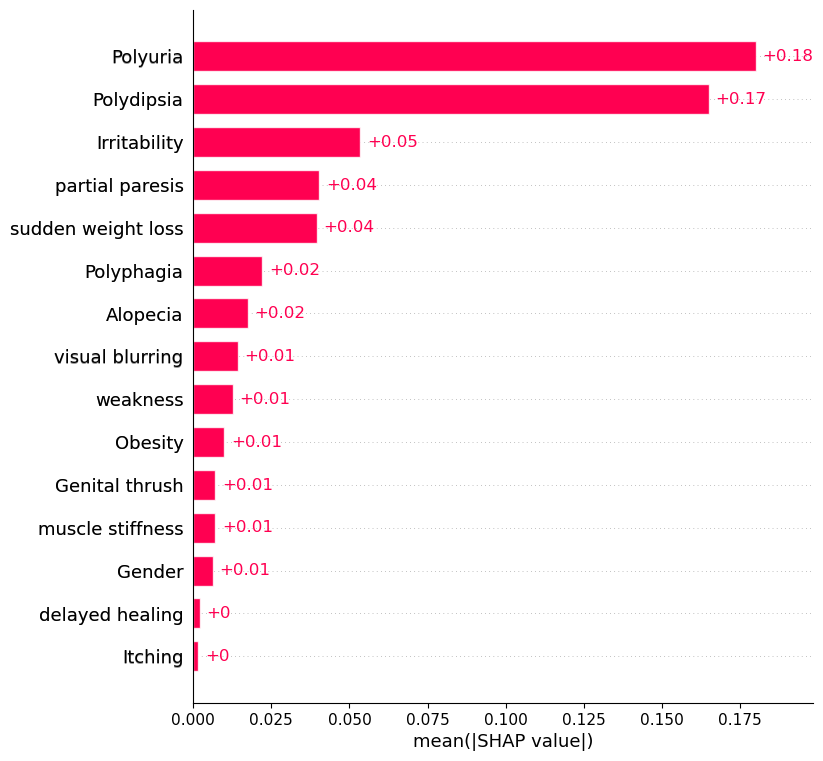

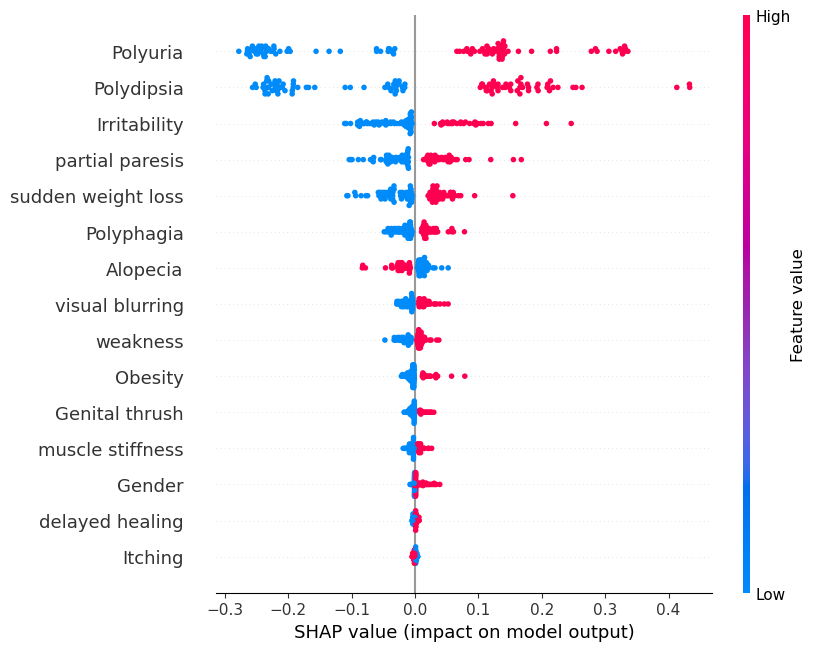

In [34]:
n = len(X_test)
explainer_g1 = shap.Explainer(model, X_test.values[0:n], algorithm='permutation')
shap_values = explainer_g1(X_test.values[0:n])
for i, c in enumerate(X_test.columns):
    shap_values.feature_names[i] = c
shap_values.data = X_test.values[0:n]

# Visualize SHAP Values
shap.plots.bar(shap_values, max_display=30)
shap.plots.beeswarm(shap_values, max_display=30)